In [14]:
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../data/replicas/df_replicas_final.csv')

In [3]:
df.shape

(79033, 201)

# Proof of Gaussian replicas dist

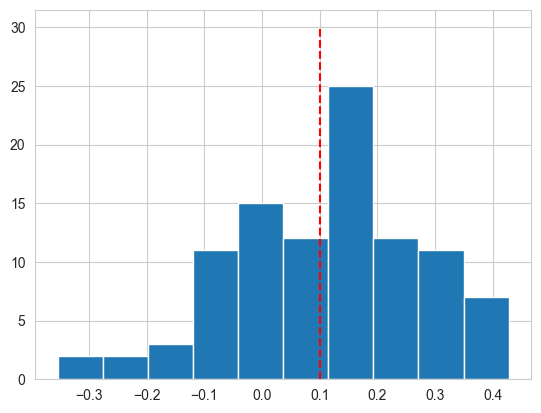

In [4]:
rand_row = np.random.randint(len(df))
df.iloc[rand_row][[f'dsigma_dOmega_replica_{it}' for it in range(100)]].hist()
plt.vlines(x=df.iloc[rand_row]['dsigma_dOmega_predicted'], ymin=0, ymax=30, color='red', linestyle='dashed')

# Relative difference

In [19]:
for i in range(91):
    df[f'dsigma_dOmega_replica_prediction_diff_{i}'] = (df[f'dsigma_dOmega_replica_{i}']-df['dsigma_dOmega_predicted'])/df['dsigma_dOmega_predicted']

In [21]:
def build_replica_df(
    df: pd.DataFrame,
    x_col: str,
    *,
    replica_prefix: str = "dsigma_dOmega_replica_prediction_diff_",
    n_replica: int = 100,
    value_name: str = "diff_cross_section",
    keep_cols: list[str] | None = None,
    auto_detect: bool = True,
) -> pd.DataFrame:
    """
    Returns long df with columns: [x_col, (keep_cols...), 'replica', value_name]
    Only melts replica columns (fastest + correct).
    """

    keep_cols = keep_cols or []
    id_vars = [x_col] + keep_cols

    # expected names
    expected = [f"{replica_prefix}{i}" for i in range(n_replica)]
    existing = [c for c in expected if c in df.columns]

    # if nothing matches, try auto-detect by prefix
    if auto_detect and len(existing) == 0:
        pref = str(replica_prefix)
        existing = [c for c in df.columns if str(c).startswith(pref)]

        # sort by trailing integer if present
        def _key(s):
            m = re.search(r"(\d+)$", str(s))
            return int(m.group(1)) if m else 10**12

        existing = sorted(existing, key=_key)

    if len(existing) == 0:
        # fail loudly with helpful info
        sample_cols = list(df.columns[:20])
        raise ValueError(
            f"No replica columns found.\n"
            f"Expected like: {replica_prefix}0 ... {replica_prefix}{n_replica-1}\n"
            f"First columns in df: {sample_cols}"
        )

    return df.melt(
        id_vars=id_vars,
        value_vars=existing,
        var_name="replica",
        value_name=value_name
    )

In [22]:
def joint_density_plot(
    df,
    x_col,
    y_col="diff_cross_section",
    x_bins=15,
    y_bins=500,
    clip_quantile=0.99,
    cmap="viridis",
    xlabel=None,
    ylabel="delta"
):
    # ----------------------------
    # 1. Clip y outliers
    # ----------------------------
    q = df[y_col].quantile(clip_quantile)
    df = df[(df[y_col] > -q) & (df[y_col] < q)]

    x = df[x_col].to_numpy()
    y = df[y_col].to_numpy()

    # ----------------------------
    # 2. Explicit bin edges
    # ----------------------------
    x_edges = np.linspace(x.min(), x.max(), x_bins + 1)
    y_edges = np.linspace(y.min(), y.max(), y_bins + 1)

    # ----------------------------
    # 3. 2D histogram (density)
    # ----------------------------
    H, _, _ = np.histogram2d(
        x, y,
        bins=[x_edges, y_edges],
        density=False
    )

    # ----------------------------
    # 4. Layout (manual, stable)
    # ----------------------------
    fig = plt.figure(figsize=(7, 7))
    gs = GridSpec(
        2, 2,
        width_ratios=[4, 1],
        height_ratios=[1, 4],
        hspace=0.05,
        wspace=0.05
    )

    ax_top = fig.add_subplot(gs[0, 0])
    ax_right = fig.add_subplot(gs[1, 1])
    ax_main = fig.add_subplot(gs[1, 0])

    # ----------------------------
    # 5. Main heatmap
    # ----------------------------
    mesh = ax_main.pcolormesh(
        x_edges,
        y_edges,
        H.T,
        cmap=cmap,
        shading="auto"
    )

    ax_main.axhline(0, color="#1b1687")
    ax_main.set_xlabel(xlabel or x_col)
    ax_main.set_ylabel(ylabel)

    # ----------------------------
    # 6. Marginals
    # ----------------------------
    ax_top.hist(x, bins=x_edges, color="steelblue")
    ax_right.hist(y, bins=y_bins, orientation="horizontal", color="steelblue")

    ax_top.set_xticklabels([])
    ax_right.set_yticklabels([])

    # ----------------------------
    # 7. Colorbar (rightmost)
    # ----------------------------
    cbar = fig.colorbar(mesh, ax=[ax_main, ax_top, ax_right], pad=0.02)
    cbar.set_label("Density")


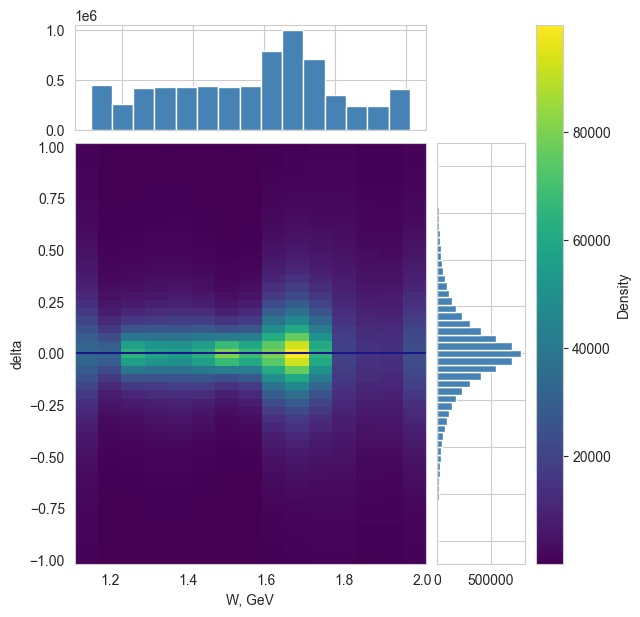

In [23]:
joint_density_plot(
    build_replica_df(df, "W"),
    x_col="W",
    x_bins=15,
    y_bins=51,
    xlabel="W, GeV"
)

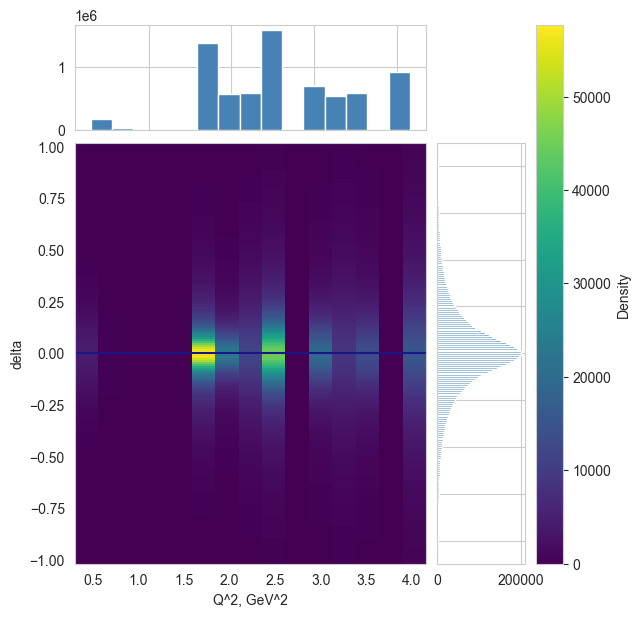

In [24]:
joint_density_plot(
    build_replica_df(df, "Q2"),
    x_col="Q2",
    x_bins=15,
    y_bins=200,
    xlabel="Q^2, GeV^2"
)

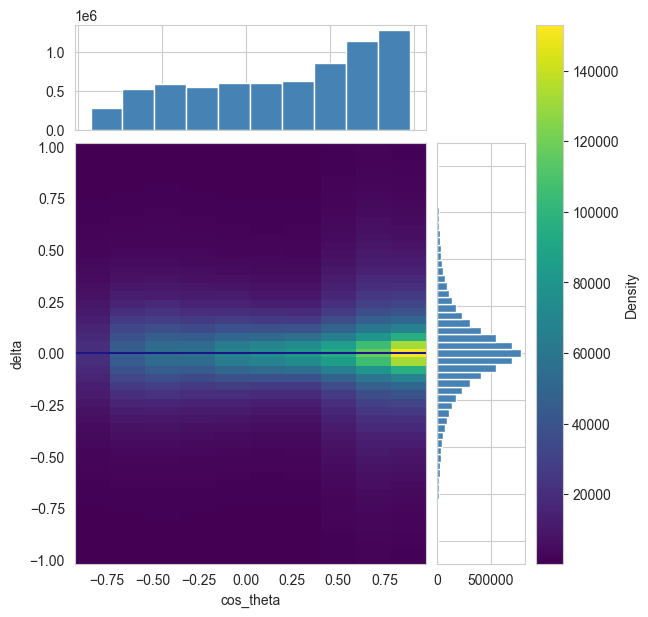

In [25]:
joint_density_plot(
    build_replica_df(df, "cos_theta"),
    x_col="cos_theta",
    x_bins=10,
    y_bins=51,
    xlabel="cos_theta"
)

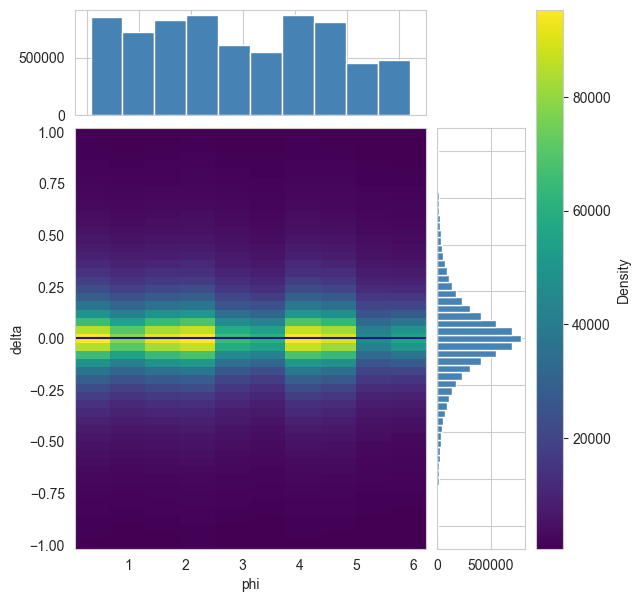

In [26]:
joint_density_plot(
    build_replica_df(df, "phi"),
    x_col="phi",
    x_bins=10,
    y_bins=51,
    xlabel="phi"
)

# Generate full grid replicas predictions

In [ ]:
df_full_grid = pd.read_csv('../data/replicas/df_replicas_grid_final.csv',
                           header=0)

In [ ]:
df_full_grid

In [ ]:
[i for i in range(5*10**6, 100*10**6)]

# Graveyard

In [ ]:
# df['rel_diff'] = df.apply(lambda x: [x['dsigma_dOmega_predicted'] - x[f"dsigma_dOmega_replica_{i}"] for i in range(91)], axis=1)
#
# df_agg = df.groupby('Q2').rel_diff.agg(sum)
# df_agg = pd.DataFrame(df_agg).reset_index()
# df_agg['rel_diff_mean'] = df_agg.rel_diff.apply(lambda x: np.mean(x))
# df_agg['rel_diff_std'] = df_agg.rel_diff.apply(lambda x: np.std(x))
# df_agg.sort_values("Q2", inplace=True)
#
# df_agg['rel_diff_mean'] = df_agg.rel_diff.apply(lambda x: np.mean(x))
# df_agg['rel_diff_std'] = df_agg.rel_diff.apply(lambda x: np.std(x))
# df_agg.sort_values("Q2", inplace=True)
#
# plt.plot(df_agg.Q2, df_agg.rel_diff_mean)
# plt.errorbar(df_agg.Q2, df_agg.rel_diff_mean, yerr=df_agg.rel_diff_std)

# stats = pd.DataFrame({
#     "W": df["W"],
#     "mean": df["rel_diff"].apply(np.mean),
#     "std": df["rel_diff"].apply(np.std),
#     "p50": df["rel_diff"].apply(lambda x: np.percentile(x, 50)),
#     "p95": df["rel_diff"].apply(lambda x: np.percentile(x, 95)),
# })
# stats = stats.sort_values("W")
#
# plt.figure()
# plt.plot(stats["W"], stats["mean"], label="mean")
# plt.fill_between(
#     stats["W"],
#     stats["mean"] - stats["std"],
#     stats["mean"] + stats["std"],
#     alpha=0.3,
#     label="±1σ",
# )
# plt.plot(stats["W"], stats["p95"], linestyle="--", label="95th percentile")
#
# plt.xlabel("W")
# plt.ylabel("relative difference")
# plt.legend()
# plt.title("Deviation envelope vs W")
# plt.show()